# A first technique on Neural Network Interpretability 

------------------------------------------------------
*Neural Networks. Bachelor in Data Science and Engineering*

*Pablo M. Olmos pamartin@ing.uc3m.es*

------------------------------------------------------

In this notebook, we will present a simple instance of a technique known as **Activation Maximization**, a method to visualize neural networks that aims to maximize the activation of certain neurons. 

During normal training, one would iteratively tune the weights and biases of the network such that the error, or loss, of the neural network is minimized across training examples in the data set. On the other hand, activation maximization flips this around: after the classifier has been trained, we want to iteratively find **the parts of the data that the model thinks belongs to a class**.

Lets first train an MLP model over MNIST and then describe the technique.

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  #To get figures with high quality!

import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt

Load database

In [ ]:
### Run this cell

from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

# Download and load the training  data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
dataiter = iter(trainloader)   #To iterate through the dataset

images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)




<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


Lets plot an image from the trainset

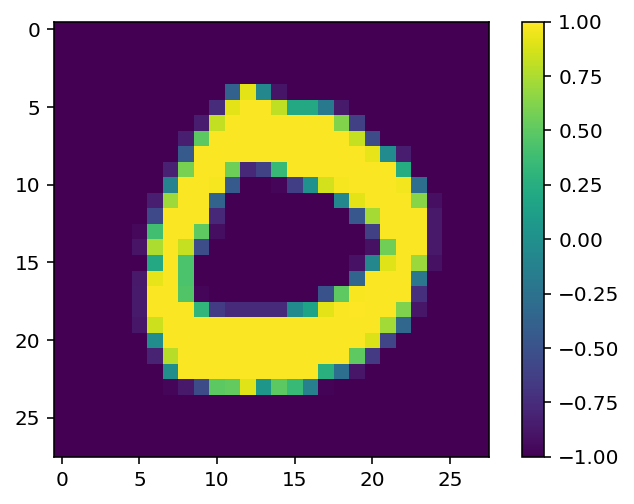

In [ ]:
plt.imshow(images[1].numpy().reshape([28,28]), cmap='viridis')
plt.colorbar()

Create a validation set

In [ ]:
import copy


validloader = copy.deepcopy(trainloader)  # Creates a copy of the object 

#We take the first 45k images for training
trainloader.dataset.data = trainloader.dataset.data[:45000,:,:]
trainloader.dataset.targets = trainloader.dataset.targets[:45000]

#And the rest for validation
validloader.dataset.data = validloader.dataset.data[45000:,:,:]
validloader.dataset.targets = validloader.dataset.targets[45000:]



We define a three layer MLP to classify MNIST ...

In [ ]:
class MLPdrop(nn.Module):
    def __init__(self,dimx,hidden1,hidden2,nlabels,prob): #Nlabels will be 10 in our case
        super().__init__()
        
        self.output1 = nn.Linear(dimx,hidden1)
        
        self.output2 = nn.Linear(hidden1,hidden2)
        
        self.output3 = nn.Linear(hidden2,nlabels)
    
        self.relu = nn.Tanh()
        
        self.logsoftmax = nn.LogSoftmax(dim=1)   
        
        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=prob)
        
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.output1(x)
        x = self.relu(x)  
        x = self.dropout(x)     
        x = self.output2(x)
        x = self.relu(x)       
        x = self.output3(x)
        x = self.logsoftmax(x) #YOUR CODE HERE
        return x

And extend the class to incorporate training/validation methods ...

In [ ]:
class MLPdrop_extended(MLPdrop):
    
    #Your code here
    
    def __init__(self,dimx,hidden1,hidden2,nlabels,prob,epochs=100,lr=0.001):
        
        super().__init__(dimx,hidden1,hidden2,nlabels,prob)  #To initialize `MLP`!
        
        self.lr = lr #Learning Rate
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.NLLLoss()             
        
        # A list to store the loss evolution along training
        
        self.loss_during_training = [] 
        
        self.valid_loss_during_training = [] 
        
    def trainloop(self,trainloader,validloader):
        
        # set model back to train mode
        self.train()
        
        # Optimization Loop
        
        for e in range(int(self.epochs)):
            
            # Random data permutation at each epoch
            
            running_loss = 0.
            
            for images, labels in trainloader:              
        
                self.optim.zero_grad()  #TO RESET GRADIENTS!
            
                out = self.forward(images.view(images.shape[0], -1))

                #Your code here
                loss = self.criterion(out,labels)

                running_loss += loss.item()

                #Your code here
                loss.backward()
                
                #Your code here
                self.optim.step()
                
                
            self.loss_during_training.append(running_loss/len(trainloader))
            
            # Validation Loss
            
            # Turn off gradients for validation, saves memory and computations
            with torch.no_grad(): 
                
                # set model to evaluation mode
                self.eval()
                
                running_loss = 0.
                
                for images,labels in validloader:
                    
                    out = self.forward(images.view(images.shape[0], -1))

                    #Your code here
                    loss = self.criterion(out,labels)

                    running_loss += loss.item()   
                    
                self.valid_loss_during_training.append(running_loss/len(validloader))    
                    
            # set model back to train mode
            self.train()
                    
            if(e % 1 == 0): # Every 10 epochs

                print("Epoch %d. Training loss: %f, Validation loss: %f" 
                      %(e,self.loss_during_training[-1],self.valid_loss_during_training[-1]))

    def eval_performance(self,dataloader):
        
        loss = 0
        accuracy = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            
            # set model to evaluation mode
            self.eval()

            for images,labels in dataloader:

                probs = self.forward(images.view(images.shape[0], -1))

                top_p, top_class = probs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))
    
            return accuracy/len(dataloader)

Lets train the network and validate results ...

In [ ]:
my_MLP_drop = MLPdrop_extended(dimx=784,hidden1=128,hidden2=64,nlabels=10,epochs=10,lr=1e-3,prob=0.2)

my_MLP_drop.trainloop(trainloader,validloader)

Epoch 0. Training loss: 0.431491, Validation loss: 0.243969
Epoch 1. Training loss: 0.233329, Validation loss: 0.213159
Epoch 2. Training loss: 0.195944, Validation loss: 0.165642
Epoch 3. Training loss: 0.173089, Validation loss: 0.166151
Epoch 4. Training loss: 0.157297, Validation loss: 0.147722
Epoch 5. Training loss: 0.148197, Validation loss: 0.133128
Epoch 6. Training loss: 0.138627, Validation loss: 0.143162
Epoch 7. Training loss: 0.136085, Validation loss: 0.127911
Epoch 8. Training loss: 0.132343, Validation loss: 0.136848
Epoch 9. Training loss: 0.122884, Validation loss: 0.128054


Lets check train, validation, and test accuracies

In [ ]:
print(my_MLP_drop.eval_performance(trainloader))
print(my_MLP_drop.eval_performance(validloader))
print(my_MLP_drop.eval_performance(testloader))

tensor(0.9736)
tensor(0.9610)
tensor(0.9639)


## Activation Maximization

We want to see **which parts of the image the neural network believes is important towards its decision** in which digit it is. To do so, we're going to follow the next steps:

1) We are going to fix the parameters of the network, setting the `requires_grad` flag to `False` for every parameter.

2) We define a new set of Pytorch parameters which represent an input image that we will train to get a high confidence at a certain class at the output of the MLP. Hence, **we do not train the network itself but the input to such network**.

3) We will visualize the result.


Lets go step by step. First, we desable `requires_grad` for all parameters in the MLP network is straightforward:

In [ ]:
for param in my_MLP_drop.parameters():
  param.requires_grad = False

Now we define a different class that inherits from `nn.Module` to define the new set of parameters (inputs to the MLP network), a forward method, which consists on evaluating an input MLP network for the input tensor of parameters, and a training method that evaluates the distance between the desired confidence at a certain class and the confidence we are getting for the current input.

In [ ]:
class Optimize_NN_Input(nn.Module):

    def __init__(self,dimx,NN_trained,lr,img0): 
      
        # NN_trained is an already trained NN

        # img0 is a user_defined initialization for the input image
        
        super().__init__()

        self.input = nn.Parameter(img0.reshape([1,dimx**2]),requires_grad = True)

        self.NN_trained = NN_trained

        self.lr = lr

        self.criterion = nn.MSELoss() # We use mean squared error to match output MLP probabilities

        self.optim = optim.Adam(self.parameters(), self.lr)

        self.loss_during_training = []

    def forward(self):

        # We evaluate the output of the MLP network for the current input 

        logprobs = self.NN_trained.forward(self.input)

        return logprobs

    def trainloop(self,category,true_log_prob,sgd_iter):

        # category is the class we're focusing on

        # true_log_prob is the desired confidence (output probability) for such category

        # We run SGD for a certain number sgd_iter of iterations

        for i in range(sgd_iter):

          self.optim.zero_grad()  

          logprobs = self.forward()

          loss = self.criterion(logprobs[0,category].view(true_log_prob.shape),true_log_prob)

          self.loss_during_training.append(loss)

          loss.backward()
          
          self.optim.step()

Lets create an object of the former class and visualize the result.

In [ ]:
opt_input = Optimize_NN_Input(dimx=28,NN_trained=my_MLP_drop,lr=5e-3,img0=torch.randn(28,28)*0.01)

As we have initialized the input parameters at random, certainly the current input image to the MLP network does not say much ...

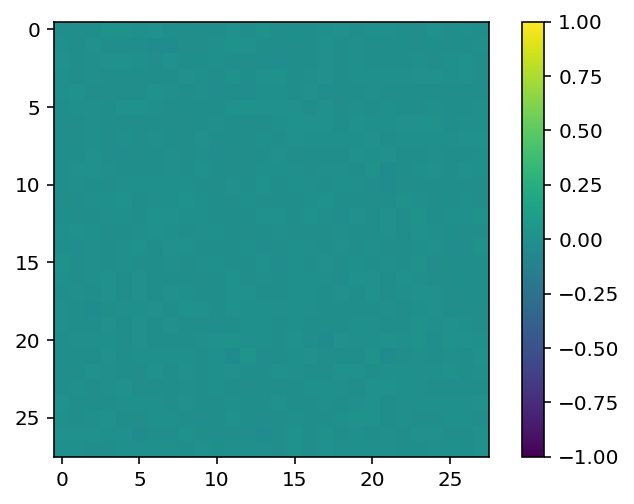

In [ ]:
plt.imshow(opt_input.input.detach().numpy().reshape([28,28]), cmap='viridis',vmin=-1,vmax=1)
plt.colorbar()

Before moving forward, lets check the `requires_grad` flag of all parameters of the model. Does the result of the following lines of code make any sense to you?

In [ ]:
for p in opt_input.parameters():
  print(p.requires_grad)

True
False
False
False
False
False
False


Also before moving on, lets check the log-probabilities that our current noisy input image is obtaining at the MLP output

Text(0, 0.5, 'Log-Probability')

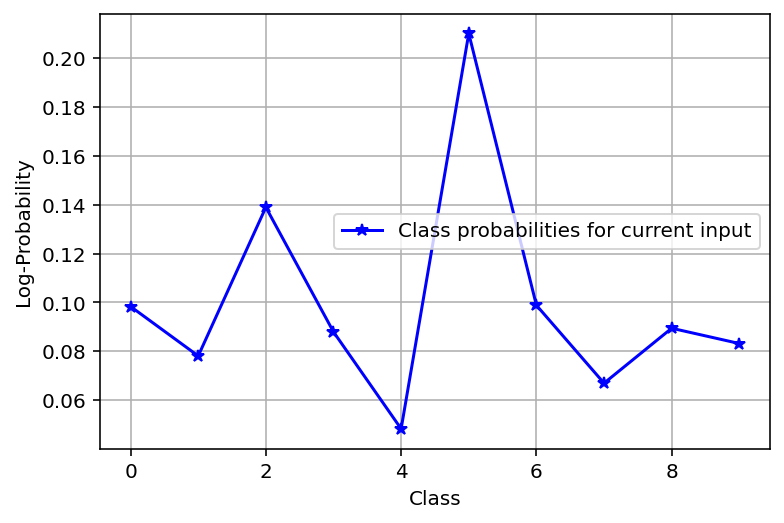

In [ ]:
noisy_inputs_probs = np.exp(opt_input.forward().detach().numpy()).reshape(10,)

plt.plot(np.arange(0,10,1),noisy_inputs_probs,'-b*',label='Class probabilities for current input')
plt.grid()
plt.legend()
plt.xlabel('Class')
plt.ylabel('Log-Probability')

Another interesting exercise before moving on. Lets evaluate the loss function and visualize the gradients w.r.t. every pixel of the input image. This is called **sensitivity** and provides important intepretability information of the MLP network.

In [ ]:
category_to_interpret = 3

confidence = 0.9999

loss = opt_input.criterion(opt_input.forward()[0,category_to_interpret].view([1]),torch.Tensor(np.log([confidence])))

In [ ]:
# Compute gradients
loss.backward()

# Get gradients
grads = opt_input.input.grad

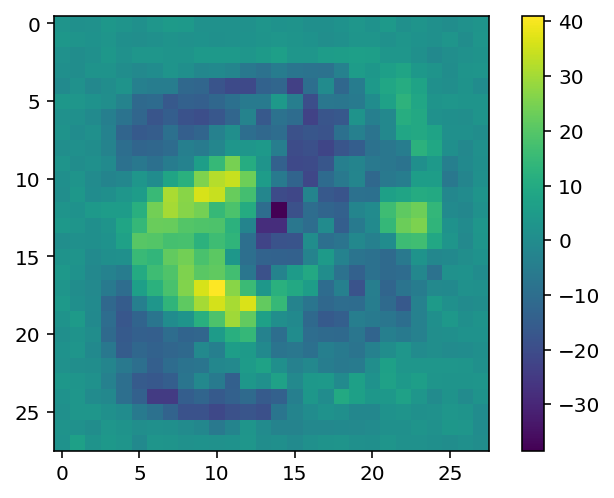

In [ ]:
# Visualize gradients

plt.imshow(grads.detach().numpy().reshape([28,28]), cmap='viridis')
plt.colorbar()

As you can see, the result certainly resembles the shape of the image class of interest.

Lets optimize the input image 

In [ ]:
opt_input.trainloop(category_to_interpret,torch.Tensor(np.log([confidence])),int(500))

Text(0, 0.5, 'Loss function')

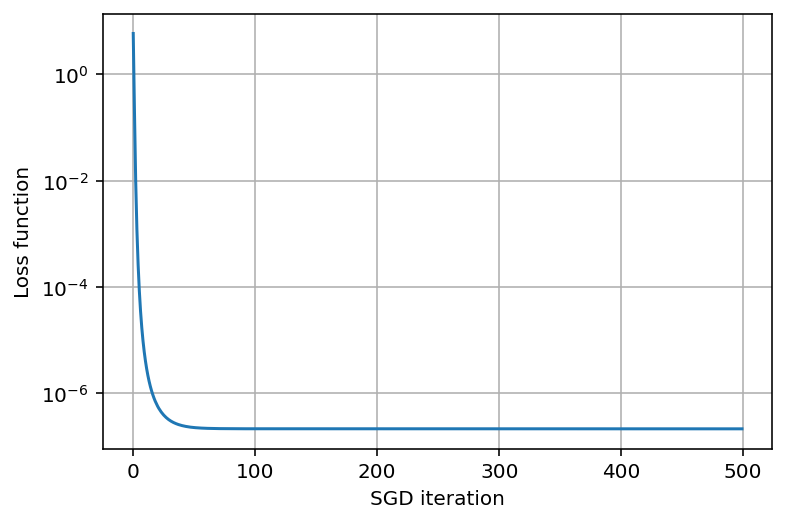

In [ ]:
# Plot loss function

plt.semilogy(opt_input.loss_during_training)
plt.grid()
plt.xlabel('SGD iteration')
plt.ylabel('Loss function')

We can compare the probabilities that we obtain with the initial ones we got for the random input image

Text(0, 0.5, 'Log-Probability')

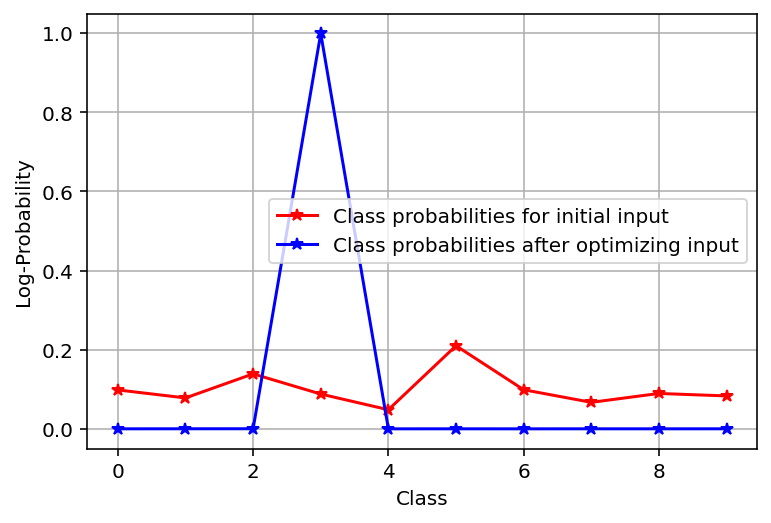

In [ ]:
optimized_inputs_probs = np.exp(opt_input.forward().detach().numpy()).reshape(10,)

plt.plot(np.arange(0,10,1),noisy_inputs_probs,'-r*',label='Class probabilities for initial input')
plt.plot(np.arange(0,10,1),optimized_inputs_probs,'-b*',label='Class probabilities after optimizing input')
plt.grid()
plt.legend()
plt.xlabel('Class')
plt.ylabel('Log-Probability')

We observe that certainly, we are providing a very high confidence for the class 3, as expected. If we evaluate now the input image, we can see that we obtain features that indeed resemble relevant parts of a number 3.

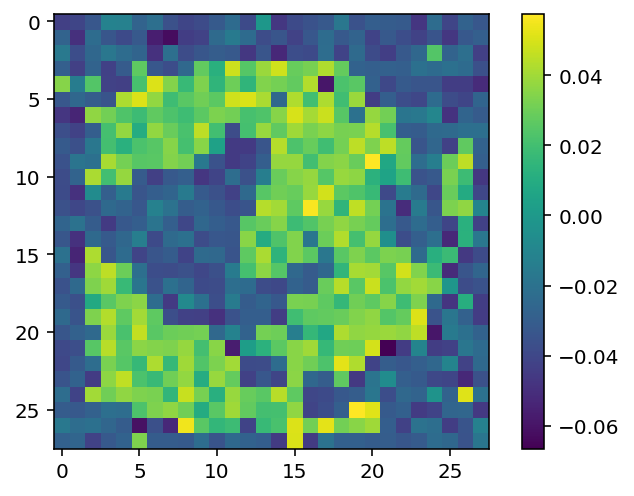

In [ ]:
x = opt_input.input.detach().numpy()
plt.imshow(x.reshape([28,28]), cmap='viridis')
plt.colorbar()

And finally we visualize again the gradients. But now they don't say much ...

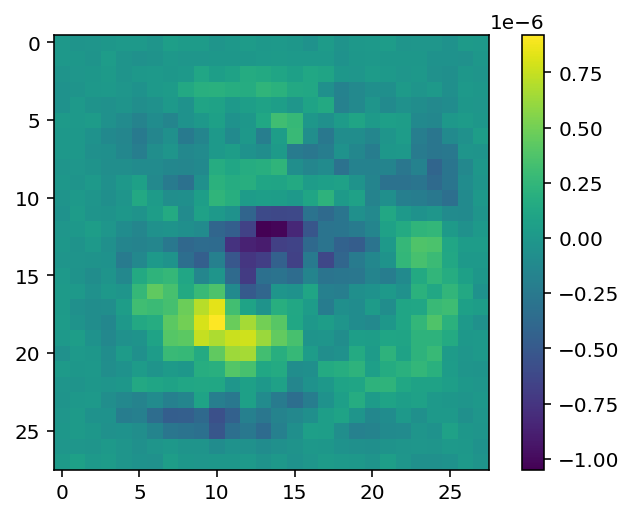

In [ ]:
g = opt_input.input.grad.detach().numpy()
plt.imshow(g.reshape([28,28]), cmap='viridis')
plt.colorbar()